# Credit Risk Modelling Application
Author: Sam Steinberg, Computer Science Graduate Student at Arizona State University

## Step 1- Data Preprocessing

Loading Libraries

In [421]:
import pandas as pd #Dataset Manipulation
import numpy as np #Math
import seaborn as sns #Graphing library
import matplotlib.pyplot as plt #Visualization
import matplotlib.style as style
#style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
#Dataset Source: https://www.kaggle.com/marcelotc/german-credit-risk

Loading Dataset 

In [422]:
df = pd.read_csv('german_credit.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
Creditability                        1000 non-null int64
Account Balance                      1000 non-null int64
Duration of Credit (month)           1000 non-null int64
Payment Status of Previous Credit    1000 non-null int64
Purpose                              1000 non-null int64
Credit Amount                        1000 non-null int64
Value Savings/Stocks                 1000 non-null int64
Length of current employment         1000 non-null int64
Instalment per cent                  1000 non-null int64
Sex & Marital Status                 1000 non-null int64
Guarantors                           1000 non-null int64
Duration in Current address          1000 non-null int64
Most valuable available asset        1000 non-null int64
Age (years)                          1000 non-null int64
Concurrent Credits                   1000 non-null int64
Type of apartment                    10

Getting rid of columns with N/A and missing values

In [423]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

#Dropping "id" and "member_id" columns since they are useless to the model
df.drop(df.columns[[0,1]], axis = 1, inplace = False)
df

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,24,2,3,1987,1,3,2,3,...,4,1,21,3,1,1,2,2,1,1
996,0,1,24,2,0,2303,1,5,4,3,...,1,1,45,3,2,1,3,1,1,1
997,0,4,21,4,0,12680,5,5,4,3,...,4,4,30,3,3,1,4,1,2,1
998,0,2,12,2,3,6468,5,1,2,3,...,1,4,52,3,2,1,4,1,2,1


Exploring Variables

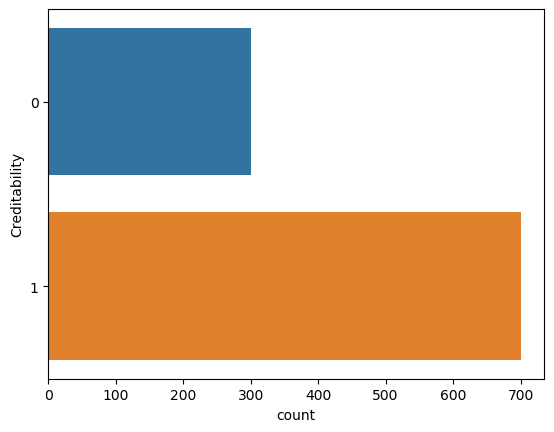

In [424]:
sns.countplot(y = "Creditability", data = df)
plt.show()

Since only 30% of customers do not have credibility, I will make class weights balanced in the model.

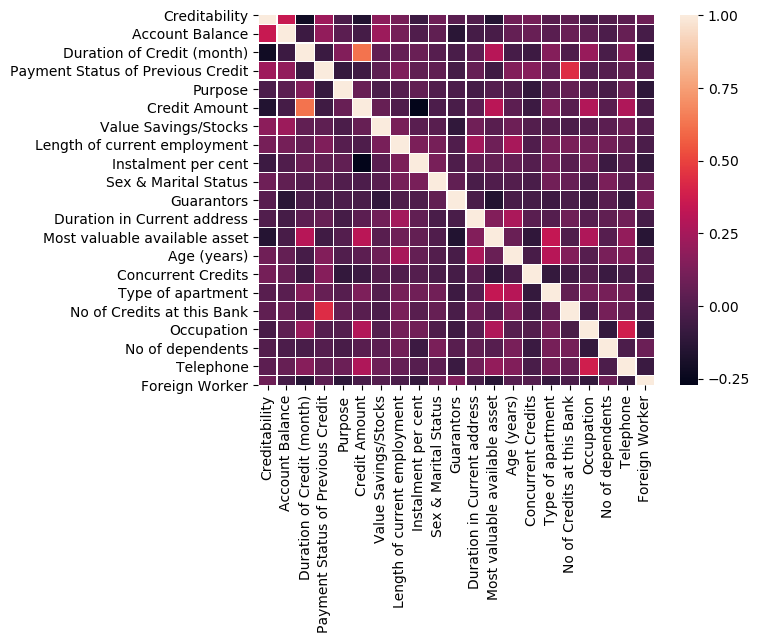

In [425]:
style.use('default')
sns.heatmap(df.corr(), linewidth= 0.1)
plt.show()

No variables correlate with one another besides "Duration of Credit" and "Credit Amount." This is to be expected.

In [426]:
style.use('default')
#plt.bar(df['Age (years)'], df['Creditability'])

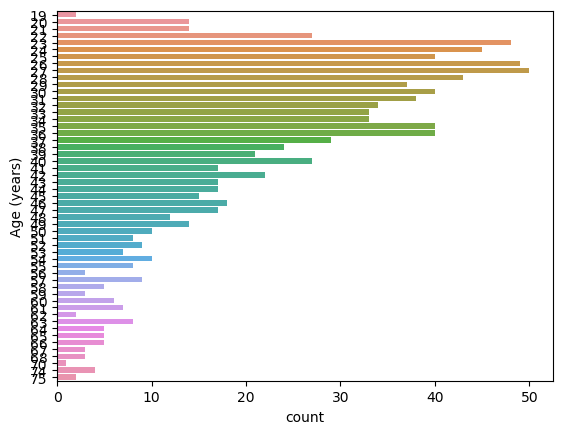

In [427]:
sns.countplot(y = "Age (years)", data = df)
plt.show()

Most of the people applying for loans are less than 45 years of age. 

Splitting Dataset into dependent and independent variables

In [428]:
x = df.iloc[:,1:21].values #Independent variables
y = df.iloc[:,0].values #Dependent variable 

Splitting Data into training and test sets

In [429]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 0) #Test size of 20% gives best results for this model

Feature Scaling our variables so they are normalized for the model

In [430]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Step 2- Comparing Algorithms

In [431]:
from sklearn.model_selection import KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

Fitting data on multiple classification models to see which one gives the best results.

In [432]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))

Evaluating each model. We use recall as our primary evaluation metric since we want to avoid lending out a loan to someone who is credible but in reality is not (False Negative). This is better than a False Positive, where we don't lend a loan out to someone who is not credible when in reality they are.

LR: 0.876817 (0.044754)
LDA: 0.874796 (0.044931)
KNN: 0.896259 (0.024848)
CART: 0.756531 (0.042703)
NB: 0.752231 (0.035149)
RF: 0.830013 (0.039781)
SVM: 0.914730 (0.038936)


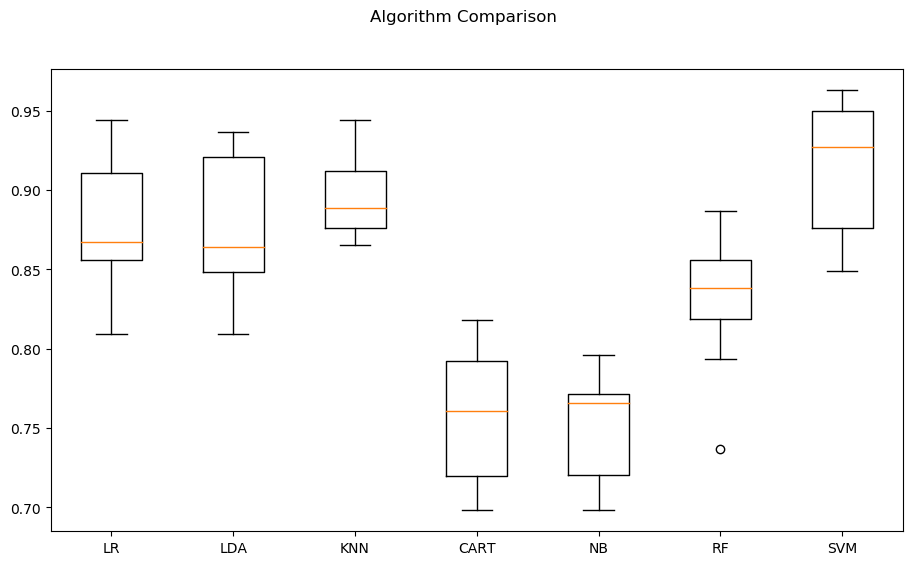

In [433]:
results = []
names = []
scoring = 'recall' 
seed = 1

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed)
        cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

- SVM and KNN had the highest cross validation scores, so we will train our model using one of these two algorithms

## Step 3- Evaluating Models

### 1) SVM

Evaluating Model

In [434]:
'''
param_grid = {"gamma":['scale', 'auto'],
              "kernel":['sigmoid'],
              "class_weight":['balanced'],
              "coef0": [0.5,1,1.3,1.4,1.5,1.8,2,3,4,5,6,7]} 

grid_search = GridSearchCV(SVC(), param_grid=param_grid, refit = True, scoring = 'recall', verbose = 3) 
grid_search.fit(x_train, y_train)

print("Best Score: " + str(grid_search.best_score_))
print("Best Parameters: " + str(grid_search.best_params_))

svm_grid_pred = grid_search.predict(x_test) 

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,svm_grid_pred))
print(classification_report(y_test, svm_grid_pred)) 
'''

'\nparam_grid = {"gamma":[\'scale\', \'auto\'],\n              "kernel":[\'sigmoid\'],\n              "class_weight":[\'balanced\'],\n              "coef0": [0.5,1,1.3,1.4,1.5,1.8,2,3,4,5,6,7]} \n\ngrid_search = GridSearchCV(SVC(), param_grid=param_grid, refit = True, scoring = \'recall\', verbose = 3) \ngrid_search.fit(x_train, y_train)\n\nprint("Best Score: " + str(grid_search.best_score_))\nprint("Best Parameters: " + str(grid_search.best_params_))\n\nsvm_grid_pred = grid_search.predict(x_test) \n\nfrom sklearn.metrics import classification_report, confusion_matrix\nprint(confusion_matrix(y_test,svm_grid_pred))\nprint(classification_report(y_test, svm_grid_pred)) \n'

### 2) KNN 

In [435]:
'''
param_grid = {"n_neighbors": [25,25,30,31,32,33,34,35,40],
              "weights": ['uniform', 'distance'],
              "algorithm": ['auto','ball_tree', 'kd_tree', 'brute'],
               "leaf_size": [10,11,12,13,14,15,20,25]} 

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, refit = True, scoring = 'recall', verbose = 3) 
grid_search.fit(x_train, y_train)

print("Best Score: " + str(grid_search.best_score_))
print("Best Parameters: " + str(grid_search.best_params_))

knn_grid_pred = grid_search.predict(x_test) 

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,knn_grid_pred))
print(classification_report(y_test, knn_grid_pred)) 
''' 

'\nparam_grid = {"n_neighbors": [25,25,30,31,32,33,34,35,40],\n              "weights": [\'uniform\', \'distance\'],\n              "algorithm": [\'auto\',\'ball_tree\', \'kd_tree\', \'brute\'],\n               "leaf_size": [10,11,12,13,14,15,20,25]} \n\ngrid_search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, refit = True, scoring = \'recall\', verbose = 3) \ngrid_search.fit(x_train, y_train)\n\nprint("Best Score: " + str(grid_search.best_score_))\nprint("Best Parameters: " + str(grid_search.best_params_))\n\nknn_grid_pred = grid_search.predict(x_test) \n\nfrom sklearn.metrics import classification_report, confusion_matrix\nprint(confusion_matrix(y_test,knn_grid_pred))\nprint(classification_report(y_test, knn_grid_pred)) \n'

In [436]:
knn_model = KNeighborsClassifier(algorithm= 'auto', leaf_size= 14, n_neighbors= 25, weights= 'distance')
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.29      0.43        68
           1       0.73      0.97      0.83       132

    accuracy                           0.74       200
   macro avg       0.78      0.63      0.63       200
weighted avg       0.76      0.74      0.70       200



- SVM outputs a much higher recall for customer who don't qualify for a loan (65% vs 20% for KNN). Therefore, we will use the SVM classifier to model our data.

## Step 4- Evaluating and Tuning Final Model

#### Refitting our model to SVM using best parameters

In [437]:
svm_model = SVC(kernel='sigmoid', random_state = 1, class_weight = 'balanced', coef0 =0.0)
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.56      0.78      0.65        68
           1       0.86      0.69      0.76       132

    accuracy                           0.72       200
   macro avg       0.71      0.73      0.71       200
weighted avg       0.76      0.72      0.73       200



- Our best recall score for customers who don't qualify for aa loan is 0.76. This means our model is correctly predicting a false negative 76% of the time. 

### Plotting AUC Graph
Another tool in evaluating model performance is using an AUC graph. The closer the line gets to y=1, the more accurate the model is. Our AUC score is .73. AUC scores vary from 0 to 1, with 0.5 being a poor model and 1 being a perfect model. Our model is respectable (AUC > .70).

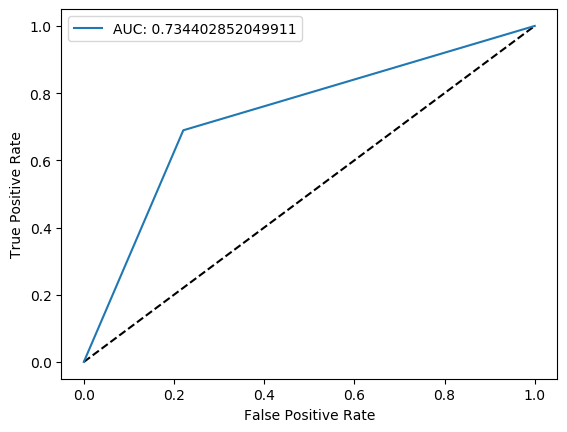

In [438]:
#Visualizing Results with AUC Graph in order to evaluate model performance
from sklearn.metrics import roc_curve, auc
fpr,tpr,threshold = roc_curve(y_test, y_pred)
auc = auc(fpr,tpr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr, label = 'AUC: ' + str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
#test set = 0.20, recall 0 = 0.78, recall 1 = 0.69, AUC = 0.73